In [22]:
import numpy as np
from scipy.io import wavfile


sample_rate, data = wavfile.read("Data/Healthy/M1/1400.wav")

print("Sampling Rate:", sample_rate)
print("Data Shape:", data.shape)
if len(data.shape) == 2:
    data = data.mean(axis=1)

segment_length = 50
num_segments = len(data) // segment_length
data = data[:num_segments * segment_length]

segments_healthy = data.reshape(num_segments, segment_length)/32768.0
print("Segments Shape:", segments_healthy.shape)

Sampling Rate: 44100
Data Shape: (448027, 2)
Segments Shape: (8960, 50)


In [23]:
import numpy as np
from scipy.io import wavfile


sample_rate, data = wavfile.read("Data/Propeller/M1/1400.wav")

print("Sampling Rate:", sample_rate)
print("Data Shape:", data.shape)
if len(data.shape) == 2:
    data = data.mean(axis=1)

segment_length = 50
num_segments = len(data) // segment_length
data = data[:num_segments * segment_length]

segments_propeller = data.reshape(num_segments, segment_length)/32768.0
print("Segments Shape:", segments_propeller.shape)

Sampling Rate: 16000
Data Shape: (165920, 2)
Segments Shape: (3318, 50)


In [24]:
import numpy as np
from scipy.io import wavfile


sample_rate, data = wavfile.read("Data/Bearing/M4/1700.wav")

print("Sampling Rate:", sample_rate)
print("Data Shape:", data.shape)
if len(data.shape) == 2:
    data = data.mean(axis=1)

segment_length = 50
num_segments = len(data) // segment_length
data = data[:num_segments * segment_length]

segments_bearing = data.reshape(num_segments, segment_length)/32768.0
print("Segments Shape:", segments_bearing.shape)

# label_array.shape = (num_segments,)

Sampling Rate: 16000
Data Shape: (165200, 2)
Segments Shape: (3304, 50)


NameError: name 'label_array' is not defined

In [18]:
segments.shape

(8960, 50)

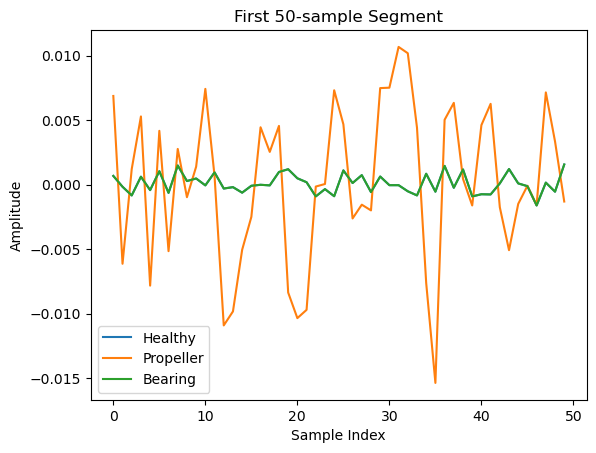

In [41]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(segments[0], label="Healthy")
plt.plot(segments_propeller[0], label="Propeller")
plt.plot(segments_bearing[0], label="Bearing")
plt.legend()
plt.title("First 50-sample Segment")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.show()

In [43]:
import numpy as np
from scipy.io import wavfile

segment_length = 50

name = ["Data/Healthy/M1/1400.wav", "Data/Bearing/M4/1700.wav"]
labels_value = [0, 1]
all_segments = []
all_labels = []

for i in range(len(name)):
    sample_rate, data = wavfile.read(name[i])
    if len(data.shape) == 2:
        data = data.mean(axis=1)
    num_segments = len(data) // segment_length
    data = data[:num_segments * segment_length]
    segments = data.reshape(num_segments, segment_length)/32768.0   # Normalization to [-1,1]
    print(name[i], segments.shape)

    labels = np.full(num_segments, labels_value[i], dtype=np.uint8)
    all_segments.append(segments)
    all_labels.append(labels)

all_segments = np.vstack(all_segments)
all_labels = np.concatenate(all_labels)
print("Before shuffle:", all_segments.shape, all_labels.shape)

indices = np.random.permutation(len(all_segments))
all_segments = all_segments[indices]
all_labels = all_labels[indices]
print("After shuffle:", all_segments.shape, all_labels.shape)

Data/Healthy/M1/1400.wav (8960, 50)
Data/Bearing/M4/1700.wav (3304, 50)
Before shuffle: (12264, 50) (12264,)
After shuffle: (12264, 50) (12264,)


In [48]:
import serial
import struct
import time

CODE_START_OF_FRAME_0 = b"\xAA"
CODE_START_OF_FRAME_1 = b"\x55"
CODE_START_OF_FRAME = CODE_START_OF_FRAME_0 + CODE_START_OF_FRAME_1
CODE_REQUEST_DATA = 0x01
CODE_DATA = 0x02
CODE_ACKNOWLEDGEMENT = 0x03
CODE_FINISH = 0x04
CODE_END = 0x05

show_print = 0

# CCITT 16-bit crc check
def crc_check(data: bytes) -> int:
    crc = 0xFFFF
    for d in data:
        crc ^= (d << 8)
        for _ in range(8):
            if (crc & 0x8000):
                crc = ((crc << 1) ^ 0x1021) & 0xFFFF
            else:
                crc = (crc << 1) & 0xFFFF
    return crc

# frame: Start of frame - data type - sequence - length - data - crc
def pack_frame(data_type: int, message_sequence: int, data: bytes) -> bytes:
    message_sequence &= 0xFFFF
    length = len(data) & 0xFFFF

    message_bytes = struct.pack("<BHH", data_type, message_sequence, length) + data
    crc = crc_check(message_bytes)
    crc_bytes = struct.pack("<H", crc)

    return CODE_START_OF_FRAME + message_bytes + crc_bytes

# Read data
def read_n_bytes(ser: serial.Serial, n: int):
    buf_all = bytearray()
    while len(buf_all) < n:
        buf = ser.read(n - len(buf_all))
        if not buf:
            return None
        buf_all += buf
    return bytes(buf_all)

# Message analysis
def read_frame(ser: serial.Serial):
    while True:
        start_of_frame_0 = ser.read(1)
        if not start_of_frame_0:
            return None
        if start_of_frame_0 == CODE_START_OF_FRAME_0:
            start_of_frame_1 = ser.read(1)
            if not start_of_frame_1:
                return None
            if start_of_frame_1 == CODE_START_OF_FRAME_1:
                break

    header = read_n_bytes(ser, 1 + 2 + 2)
    if header is None:
        return None
    data_type = header[0]
    message_sequence, length = struct.unpack("<HH", header[1:])

    data = read_n_bytes(ser, length)
    if data is None:
        return None

    crc_bytes = read_n_bytes(ser, 2)
    if crc_bytes is None:
        return None
    crc_recv = struct.unpack("<H", crc_bytes)[0]

    body = struct.pack("<BHH", data_type, message_sequence, length) + data
    if crc_check(body) != crc_recv:
        return None

    return data_type, message_sequence, data

# Send data
def send_dataset(port, baud, data_array, label_array):
    with serial.Serial(port, baud, timeout=0.2) as ser:
        time.sleep(1)
        ser.reset_input_buffer()
        ser.reset_output_buffer()

        # Initialization
        acked_count = 0
        acked_seqs = set()
        time_record = time.time()
        print("Ready for sending data.")

        while True:
            # Waiting for data request
            frame_request = read_frame(ser)

            # Time out
            if frame_request is None:
                if time.time() - time_record > 2:
                    print(f"Current progress: {acked_count} / {data_array.shape[0]}")
                    time_record = time.time()
                continue

            data_type_request, message_sequence_request, data_request = frame_request
            if(show_print):
                print("Received data: type =", hex(data_type_request),
                      "message_sequence =", message_sequence_request,
                      "len =", len(data_request))

            # End the progress
            if data_type_request == CODE_END:
                print("Received END from STM32. Exit.")
                return

            # Wait for the correct code
            if data_type_request != CODE_REQUEST_DATA:
                continue

            # Over data boundary
            if message_sequence_request >= data_array.shape[0]:
                ser.write(pack_frame(CODE_FINISH, message_sequence_request, b""))
                print(f"Sent FINISH at seq={message_sequence_request}. Exit.")
                return

            # Sending data
            data_row = data_array[message_sequence_request]
            if len(data_row) != segment_length:
                raise ValueError(f"The {message_sequence_request} data length is {len(data_row)}, which should be {segment_length}")

            label = int(label_array[message_sequence_request])
            message = struct.pack(f"<B{segment_length}d", label_array[message_sequence_request], *data_row.tolist())
            ser.write(pack_frame(CODE_DATA, message_sequence_request, message))
            if(show_print):
                print("Transmit DATA: message_sequence =", message_sequence_request)

            # Waiting for acknowledgement of the corresponding sequence
            t_deadline = time.time() + 2.0
            while True:
                if time.time() > t_deadline:
                    print("Acknowledgement waiting is timeout, back to waiting for request")
                    break

                frame_acknowledgement = read_frame(ser)
                if frame_acknowledgement is None:
                    continue

                data_type_acknowledgement, message_sequence_acknowledgement, data_acknowledgement = frame_acknowledgement
                
                # End the progress
                if data_type_acknowledgement == CODE_END:
                    print("Received END from STM32. Exit.")
                    return

                # Wait for the correct code
                if data_type_acknowledgement != CODE_ACKNOWLEDGEMENT:
                    continue

                # Only wait for the correct sequence acknowledgement
                if message_sequence_acknowledgement != message_sequence_request:
                    continue
                    
                if(show_print):
                    print("Received data: type =", hex(data_type_acknowledgement),
                      "message_sequence =", message_sequence_acknowledgement,
                      "len =", len(data_acknowledgement))

                # 0: everything is good before acknowledgement; 1: there is an error
                status = data_acknowledgement[0] if len(data_acknowledgement) >= 1 else 0
                if status != 0:
                    print(f"Acknowledgement error: seq={message_sequence_request}, status={status}")
                else:
                    if message_sequence_request not in acked_seqs:
                        acked_seqs.add(message_sequence_request)
                        acked_count += 1
                        if acked_count % 50 == 0:
                                print(f"Current progress: {acked_count} / {data_array.shape[0]}")
                break


send_dataset('COM4', 209700, all_segments, all_labels)

Ready for sending data.
Current progress: 50 / 12264
Current progress: 100 / 12264
Current progress: 150 / 12264
Current progress: 200 / 12264
Current progress: 250 / 12264
Current progress: 300 / 12264
Acknowledgement waiting is timeout, back to waiting for request
Current progress: 330 / 12264
Current progress: 330 / 12264
Current progress: 330 / 12264
Current progress: 330 / 12264
Current progress: 330 / 12264
Current progress: 330 / 12264
Current progress: 330 / 12264
Current progress: 330 / 12264
Current progress: 330 / 12264
Current progress: 330 / 12264
Current progress: 330 / 12264
Current progress: 330 / 12264
Current progress: 330 / 12264
Current progress: 330 / 12264
Current progress: 350 / 12264
Current progress: 400 / 12264
Current progress: 450 / 12264
Current progress: 500 / 12264
Current progress: 550 / 12264
Current progress: 600 / 12264
Current progress: 650 / 12264
Current progress: 700 / 12264
Current progress: 750 / 12264
Current progress: 800 / 12264
Current progr